# DermNet 皮肤病分类模型训练与测试
基于VGG19的皮肤病图像分类模型训练和测试

## 1. 环境初始化和数据加载

In [1]:
import os
import json
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 设置matplotlib中文字体支持
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

# 过滤字体警告
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# 导入VGG19模型
from VGG19 import VGG19

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 加载类别映射和权重
with open('processed_data/category_mapping.json', 'r', encoding='utf-8') as f:
    mapping_info = json.load(f)

with open('processed_data/class_weights.json', 'r') as f:
    class_weights_dict = json.load(f)

num_classes = mapping_info['num_classes']
print(f"类别数: {num_classes}")
print(f"类别: {mapping_info['categories'][:5]}...")  # 显示前5个类别

使用设备: cuda
类别数: 23
类别: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections']...


## 2. 数据集定义

In [2]:
class DermNetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        print(f"数据集初始化完成，包含 {len(self.data)} 个样本")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if idx >= len(self.data):
            raise IndexError(f"索引 {idx} 超出范围 [0, {len(self.data)})")
            
        row = self.data.iloc[idx]
        image_path = row['image_path']
        
        # 使用cv2.imdecode来处理中文路径
        try:
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"文件不存在: {image_path}")
                
            with open(image_path, 'rb') as f:
                image_data = f.read()
            
            if len(image_data) == 0:
                raise ValueError(f"文件为空: {image_path}")
                
            nparr = np.frombuffer(image_data, np.uint8)
            image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            
            if image is None:
                raise ValueError(f"无法解码图片: {image_path}")
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        except Exception as e:
            print(f"读取图片失败 {image_path}: {str(e)}")
            raise ValueError(f"无法读取图片 {image_path}: {str(e)}")
        
        # 应用数据变换
        if self.transform:
            try:
                transformed = self.transform(image=image)
                image = transformed['image']
            except Exception as e:
                print(f"数据变换失败: {str(e)}")
                raise ValueError(f"数据变换失败: {str(e)}")
        
        return image, row['label']

# 数据增强
def get_transforms(mode='train'):
    if mode == 'train':
        return A.Compose([
            A.Resize(256, 256),
            A.RandomCrop(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.RandomRotate90(p=0.3),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

## 3. 数据加载器创建

In [3]:
# 加载数据
train_df = pd.read_csv('processed_data/train.csv')
test_df = pd.read_csv('processed_data/test.csv')

print(f"训练集大小: {len(train_df)}")
print(f"测试集大小: {len(test_df)}")

# 先检查前几行数据的路径
print("\n前3行训练数据:")
print(train_df.head(3))

# 检查路径是否存在
print(f"\n检查前3个文件是否存在:")
for i in range(min(3, len(train_df))):
    path = train_df.iloc[i]['image_path']
    exists = os.path.exists(path)
    print(f"  {i+1}. {path} - {'存在' if exists else '不存在'}")

print("\n创建数据集...")
# 创建数据集
train_dataset = DermNetDataset(train_df, transform=get_transforms('train'))
test_dataset = DermNetDataset(test_df, transform=get_transforms('test'))

print("\n测试单个样本加载...")
try:
    sample_image, sample_label = train_dataset[0]
    print(f"单个样本测试成功: 图像形状 {sample_image.shape}, 标签 {sample_label}")
except Exception as e:
    print(f"单个样本测试失败: {str(e)}")
    import traceback
    traceback.print_exc()

# 只有单个样本成功后才创建数据加载器
print("\n创建数据加载器...")
batch_size = 16  # 减小批次大小
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

print(f"训练批次数: {len(train_loader)}")
print(f"测试批次数: {len(test_loader)}")

训练集大小: 15557
测试集大小: 4002

前3行训练数据:
                                          image_path                 category  \
0  DermNet/train/Acne and Rosacea Photos/07Acne08...  Acne and Rosacea Photos   
1  DermNet/train/Acne and Rosacea Photos/07AcnePi...  Acne and Rosacea Photos   
2  DermNet/train/Acne and Rosacea Photos/07AcnePi...  Acne and Rosacea Photos   

  dataset_type  label  
0        train      0  
1        train      0  
2        train      0  

检查前3个文件是否存在:
  1. DermNet/train/Acne and Rosacea Photos/07Acne081101.jpg - 存在
  2. DermNet/train/Acne and Rosacea Photos/07AcnePittedScars.jpg - 存在
  3. DermNet/train/Acne and Rosacea Photos/07AcnePittedScars1.jpg - 存在

创建数据集...
数据集初始化完成，包含 15557 个样本
数据集初始化完成，包含 4002 个样本

测试单个样本加载...
单个样本测试成功: 图像形状 torch.Size([3, 224, 224]), 标签 0

创建数据加载器...
训练批次数: 973
测试批次数: 251


## 4. 模型初始化

In [4]:
# 创建模型
model = VGG19(num_classes=num_classes, dropout_rate=0.5).to(device)

# 可选：加载预训练权重（推荐用于医学图像）
use_pretrained = True  # 设置为True使用ImageNet预训练权重

if use_pretrained:
    import torchvision.models as models
    try:
        # 加载预训练VGG19
        pretrained_vgg = models.vgg19(pretrained=True)
        
        # 获取模型状态字典
        model_dict = model.state_dict()
        pretrained_dict = pretrained_vgg.state_dict()
        
        # 只保留特征提取层的权重
        pretrained_dict = {k: v for k, v in pretrained_dict.items() 
                          if k.startswith('features.') and k in model_dict}
        
        # 更新模型权重
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        
        print(f"✓ 成功加载ImageNet预训练权重: {len(pretrained_dict)} 层")
        
        # 可选：冻结特征提取层，只训练分类器
        freeze_features = False  # 设置为True冻结特征提取层
        if freeze_features:
            for name, param in model.named_parameters():
                if name.startswith('features.'):
                    param.requires_grad = False
            print("✓ 特征提取层已冻结")
            
    except Exception as e:
        print(f"预训练权重加载失败: {e}")
        print("使用随机初始化权重")

# 损失函数（使用类别权重）
class_weights = torch.tensor([class_weights_dict[str(i)] for i in range(num_classes)], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 优化器 - 如果使用预训练权重，使用较小的学习率
learning_rate = 0.0001 if use_pretrained else 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# 学习率调度器
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("模型初始化完成")
print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"可训练参数量: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"学习率: {learning_rate}")
print(f"使用预训练权重: {'是' if use_pretrained else '否'}")
print(f"类别权重范围: {class_weights.min():.3f} ~ {class_weights.max():.3f}")

d:\Anaconda\envs\capstone\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\capstone\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ 成功加载ImageNet预训练权重: 32 层
模型初始化完成
模型参数量: 73,528,407
可训练参数量: 73,528,407
学习率: 0.0001
使用预训练权重: 是
类别权重范围: 0.484 ~ 3.209


## 5. 训练函数

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='训练中')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 更新进度条
        pbar.set_postfix({
            'Loss': f'{running_loss/len(pbar):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='验证中')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({
                'Loss': f'{running_loss/len(pbar):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

## 6. 模型训练

In [6]:
# 训练设置
num_epochs = 300
best_val_loss = float('inf')
best_val_acc = 0.0
patience = 20
patience_counter = 0

# 创建保存目录
os.makedirs('models', exist_ok=True)

# 训练历史记录
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("开始训练...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # 训练
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 验证（使用测试集作为验证集）
    val_loss, val_acc, _, _ = validate_epoch(model, test_loader, criterion, device)
    
    # 学习率调度
    scheduler.step(val_loss)
    
    # 记录历史
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        
        # 保存最佳模型
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'mapping_info': mapping_info
        }, 'models/best_model.pth')
        
        print(f"✓ 保存最佳模型 (验证损失: {best_val_loss:.4f}, 验证准确率: {best_val_acc:.2f}%)")
    else:
        patience_counter += 1
        
    # 早停
    if patience_counter >= patience:
        print(f"早停触发，连续{patience}个epoch验证损失没有改善")
        break

print(f"\n训练完成！最佳验证准确率: {best_val_acc:.2f}%")

开始训练...

Epoch 1/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:29<00:00,  8.65it/s, Loss=2.9008, Acc=15.67%]


✓ 保存最佳模型 (验证损失: 2.9008, 验证准确率: 15.67%)

Epoch 2/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.35it/s, Loss=2.7470, Acc=20.16%]


✓ 保存最佳模型 (验证损失: 2.7470, 验证准确率: 20.16%)

Epoch 3/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.38it/s, Loss=2.7607, Acc=17.57%]



Epoch 4/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.36it/s, Loss=2.6035, Acc=23.96%]


✓ 保存最佳模型 (验证损失: 2.6035, 验证准确率: 23.96%)

Epoch 5/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.38it/s, Loss=2.4536, Acc=27.49%]


✓ 保存最佳模型 (验证损失: 2.4536, 验证准确率: 27.49%)

Epoch 6/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.31it/s, Loss=2.4526, Acc=25.74%]


✓ 保存最佳模型 (验证损失: 2.4526, 验证准确率: 25.74%)

Epoch 7/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.32it/s, Loss=2.3771, Acc=29.09%]


✓ 保存最佳模型 (验证损失: 2.3771, 验证准确率: 29.09%)

Epoch 8/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.20it/s, Loss=2.4100, Acc=29.56%]



Epoch 9/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.36it/s, Loss=2.3217, Acc=29.99%]


✓ 保存最佳模型 (验证损失: 2.3217, 验证准确率: 29.99%)

Epoch 10/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.32it/s, Loss=2.2490, Acc=32.68%]


✓ 保存最佳模型 (验证损失: 2.2490, 验证准确率: 32.68%)

Epoch 11/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.38it/s, Loss=2.2454, Acc=32.86%]


✓ 保存最佳模型 (验证损失: 2.2454, 验证准确率: 32.86%)

Epoch 12/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.29it/s, Loss=2.1150, Acc=36.66%]


✓ 保存最佳模型 (验证损失: 2.1150, 验证准确率: 36.66%)

Epoch 13/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.37it/s, Loss=2.2054, Acc=35.23%]



Epoch 14/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.38it/s, Loss=2.1005, Acc=37.23%]


✓ 保存最佳模型 (验证损失: 2.1005, 验证准确率: 37.23%)

Epoch 15/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.42it/s, Loss=2.1749, Acc=34.96%]



Epoch 16/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.36it/s, Loss=2.0494, Acc=38.31%]


✓ 保存最佳模型 (验证损失: 2.0494, 验证准确率: 38.31%)

Epoch 17/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.33it/s, Loss=2.0091, Acc=39.63%]


✓ 保存最佳模型 (验证损失: 2.0091, 验证准确率: 39.63%)

Epoch 18/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.35it/s, Loss=2.0387, Acc=39.03%]



Epoch 19/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.37it/s, Loss=1.9968, Acc=39.88%]


✓ 保存最佳模型 (验证损失: 1.9968, 验证准确率: 39.88%)

Epoch 20/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.30it/s, Loss=2.0225, Acc=39.91%]



Epoch 21/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.36it/s, Loss=1.9551, Acc=41.75%]


✓ 保存最佳模型 (验证损失: 1.9551, 验证准确率: 41.75%)

Epoch 22/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.37it/s, Loss=1.9739, Acc=40.80%]



Epoch 23/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.37it/s, Loss=1.9548, Acc=42.13%]


✓ 保存最佳模型 (验证损失: 1.9548, 验证准确率: 42.13%)

Epoch 24/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.30it/s, Loss=1.9107, Acc=43.30%]


✓ 保存最佳模型 (验证损失: 1.9107, 验证准确率: 43.30%)

Epoch 25/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.38it/s, Loss=1.9488, Acc=42.38%]



Epoch 26/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.36it/s, Loss=1.9700, Acc=44.23%]



Epoch 27/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.46it/s, Loss=1.9724, Acc=42.45%]



Epoch 28/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.36it/s, Loss=1.8633, Acc=45.68%]


✓ 保存最佳模型 (验证损失: 1.8633, 验证准确率: 45.68%)

Epoch 29/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.31it/s, Loss=1.8325, Acc=46.25%]


✓ 保存最佳模型 (验证损失: 1.8325, 验证准确率: 46.25%)

Epoch 30/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.33it/s, Loss=1.8836, Acc=44.78%]



Epoch 31/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.31it/s, Loss=1.8776, Acc=45.90%]



Epoch 32/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.33it/s, Loss=1.8868, Acc=46.40%]



Epoch 33/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.37it/s, Loss=1.8090, Acc=48.43%]


✓ 保存最佳模型 (验证损失: 1.8090, 验证准确率: 48.43%)

Epoch 34/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.31it/s, Loss=1.9005, Acc=45.85%]



Epoch 35/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.33it/s, Loss=1.7928, Acc=48.73%]


✓ 保存最佳模型 (验证损失: 1.7928, 验证准确率: 48.73%)

Epoch 36/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.37it/s, Loss=1.8306, Acc=47.55%]



Epoch 37/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.33it/s, Loss=1.7978, Acc=47.95%]



Epoch 38/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.32it/s, Loss=1.8798, Acc=47.43%]



Epoch 39/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.35it/s, Loss=1.8131, Acc=47.20%]



Epoch 40/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.35it/s, Loss=1.7253, Acc=53.47%]


✓ 保存最佳模型 (验证损失: 1.7253, 验证准确率: 53.47%)

Epoch 41/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.32it/s, Loss=1.6962, Acc=53.82%]


✓ 保存最佳模型 (验证损失: 1.6962, 验证准确率: 53.82%)

Epoch 42/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.30it/s, Loss=1.7038, Acc=53.27%]



Epoch 43/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.31it/s, Loss=1.7243, Acc=53.72%]



Epoch 44/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.29it/s, Loss=1.7476, Acc=53.50%]



Epoch 45/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.32it/s, Loss=1.7385, Acc=54.25%]



Epoch 46/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.33it/s, Loss=1.7498, Acc=54.27%]



Epoch 47/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.32it/s, Loss=1.6497, Acc=56.05%]


✓ 保存最佳模型 (验证损失: 1.6497, 验证准确率: 56.05%)

Epoch 48/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.31it/s, Loss=1.6963, Acc=56.07%]



Epoch 49/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.27it/s, Loss=1.7068, Acc=56.60%]



Epoch 50/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.29it/s, Loss=1.6787, Acc=56.87%]



Epoch 51/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.32it/s, Loss=1.7047, Acc=57.62%]



Epoch 52/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.32it/s, Loss=1.7028, Acc=57.75%]



Epoch 53/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.33it/s, Loss=1.6933, Acc=58.20%]



Epoch 54/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.26it/s, Loss=1.6825, Acc=58.02%]



Epoch 55/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.28it/s, Loss=1.7321, Acc=57.67%]



Epoch 56/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.28it/s, Loss=1.7284, Acc=58.35%]



Epoch 57/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.33it/s, Loss=1.7233, Acc=58.77%]



Epoch 58/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.30it/s, Loss=1.7170, Acc=58.82%]



Epoch 59/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.35it/s, Loss=1.7207, Acc=58.97%]



Epoch 60/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.27it/s, Loss=1.7256, Acc=58.85%]



Epoch 61/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.31it/s, Loss=1.7262, Acc=59.12%]



Epoch 62/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.39it/s, Loss=1.7071, Acc=59.45%]



Epoch 63/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.40it/s, Loss=1.7219, Acc=59.32%]



Epoch 64/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.29it/s, Loss=1.7166, Acc=59.25%]



Epoch 65/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.34it/s, Loss=1.7098, Acc=59.52%]



Epoch 66/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.36it/s, Loss=1.7167, Acc=59.17%]



Epoch 67/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.28it/s, Loss=1.7251, Acc=59.47%]

早停触发，连续20个epoch验证损失没有改善

训练完成！最佳验证准确率: 56.05%


## 7. 训练历史可视化

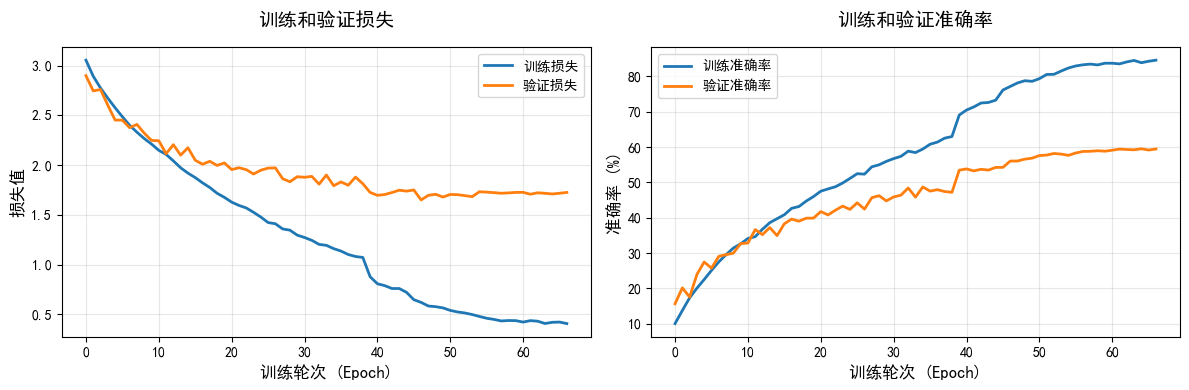

训练历史图表已保存


In [7]:
# 绘制训练历史
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失', linewidth=2)
plt.plot(val_losses, label='验证损失', linewidth=2)
plt.title('训练和验证损失', fontsize=14, pad=15)
plt.xlabel('训练轮次 (Epoch)', fontsize=12)
plt.ylabel('损失值', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='训练准确率', linewidth=2)
plt.plot(val_accs, label='验证准确率', linewidth=2)
plt.title('训练和验证准确率', fontsize=14, pad=15)
plt.xlabel('训练轮次 (Epoch)', fontsize=12)
plt.ylabel('准确率 (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/training_history.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("训练历史图表已保存")

## 8. 模型测试

In [8]:
# 加载最佳模型
checkpoint = torch.load('models/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"加载最佳模型 (Epoch {checkpoint['epoch']})")
print(f"最佳验证损失: {checkpoint['best_val_loss']:.4f}")
print(f"最佳验证准确率: {checkpoint['best_val_acc']:.2f}%")

# 在测试集上评估
print("\n在测试集上评估...")
test_loss, test_acc, test_preds, test_labels = validate_epoch(model, test_loader, criterion, device)

print(f"\n测试结果:")
print(f"测试损失: {test_loss:.4f}")
print(f"测试准确率: {test_acc:.2f}%")

加载最佳模型 (Epoch 47)
最佳验证损失: 1.6497
最佳验证准确率: 56.05%

在测试集上评估...


验证中: 100%|██████████| 251/251 [00:26<00:00,  9.39it/s, Loss=1.6497, Acc=56.05%]


测试结果:
测试损失: 1.6497
测试准确率: 56.05%


## 9. 详细评估和可视化


分类报告:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos      0.787     0.875     0.829       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions      0.650     0.601     0.625       288
                                          Atopic Dermatitis Photos      0.496     0.455     0.475       123
                                            Bullous Disease Photos      0.391     0.442     0.415       113
                Cellulitis Impetigo and other Bacterial Infections      0.302     0.397     0.343        73
                                                     Eczema Photos      0.617     0.553     0.584       309
                                      Exanthems and Drug Eruptions      0.465     0.594     0.522       101
                 Hair Loss Photos Alopecia and other Hair Diseases      0.461     0.783     0.580        60
                    

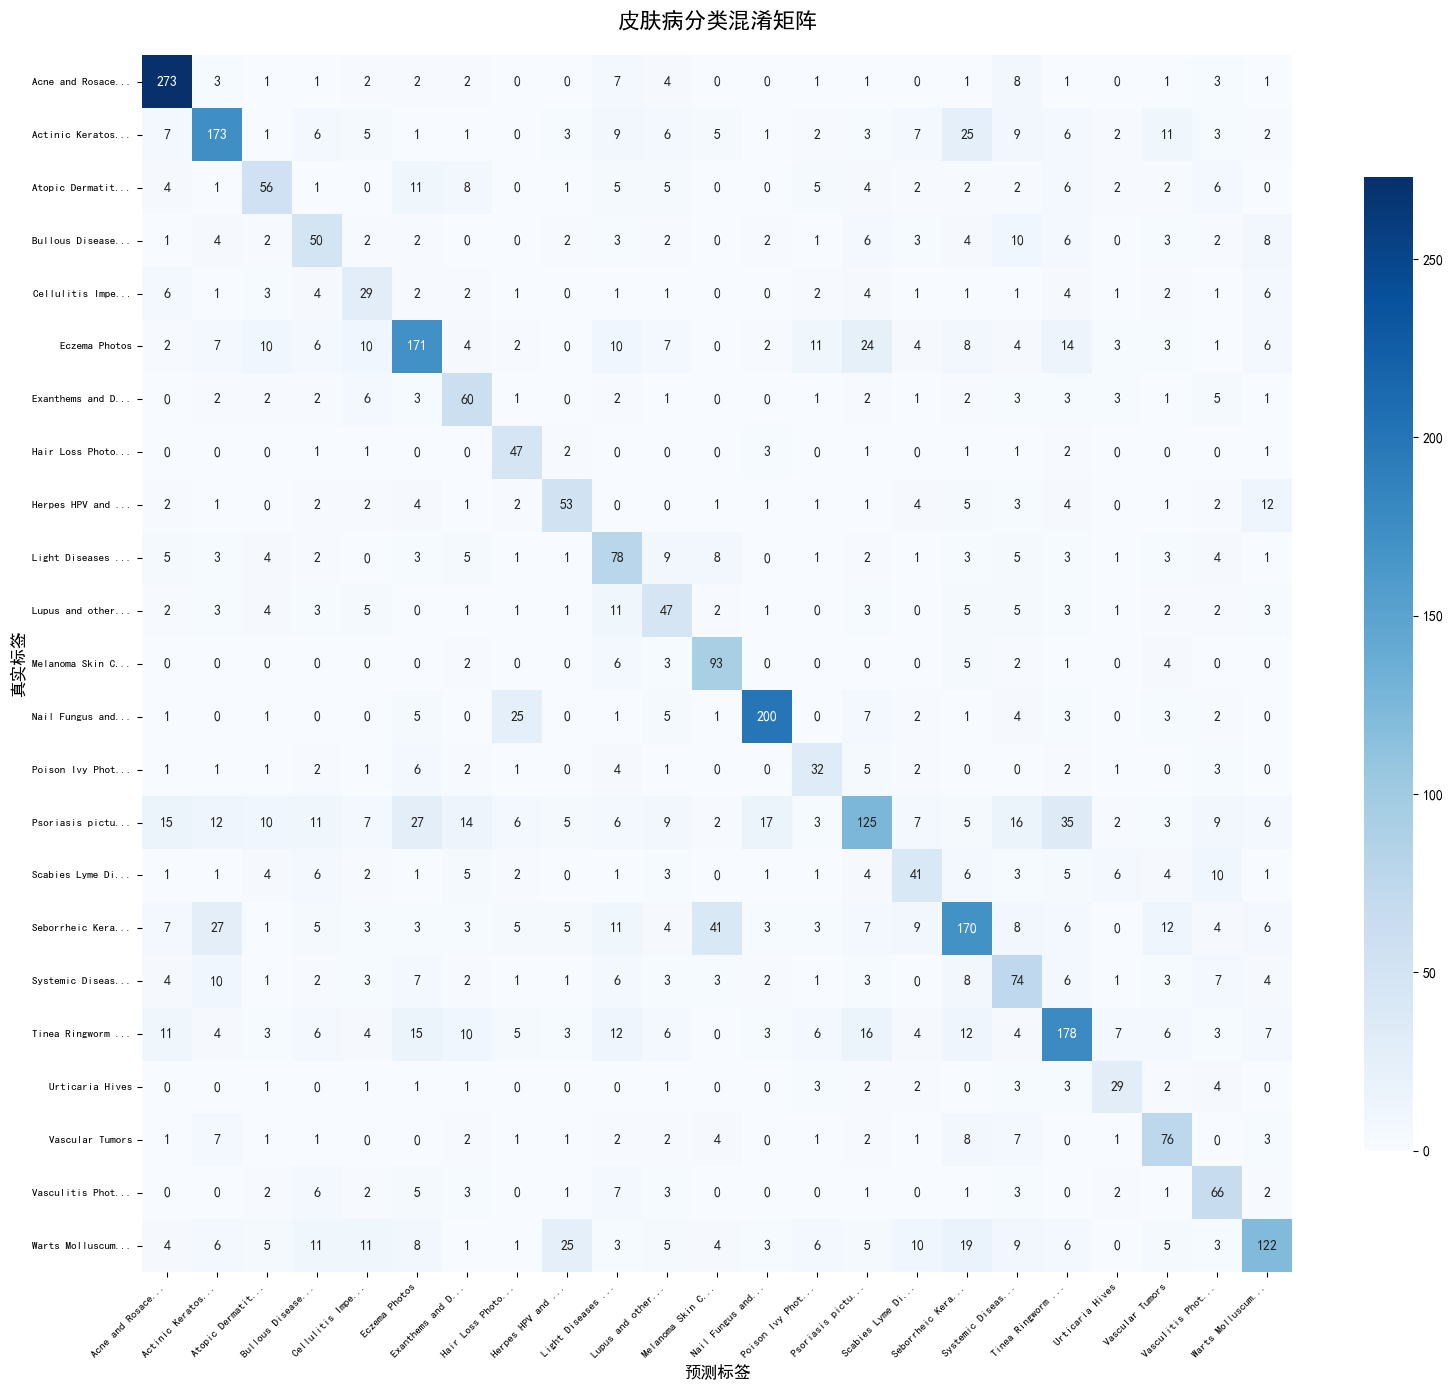


混淆矩阵已保存


In [9]:
# 分类报告
print("\n分类报告:")
print(classification_report(test_labels, test_preds, 
                          target_names=mapping_info['categories'], 
                          digits=3))

# 混淆矩阵 - 修复中文显示
cm = confusion_matrix(test_labels, test_preds)

# 简化类别名称以便显示
short_categories = []
for cat in mapping_info['categories']:
    if len(cat) > 15:  # 如果类别名太长，截取前15个字符
        short_cat = cat[:15] + "..."
    else:
        short_cat = cat
    short_categories.append(short_cat)

plt.figure(figsize=(16, 14))
# 使用更小的字体和调整参数
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=short_categories,
            yticklabels=short_categories,
            cbar_kws={'shrink': 0.8})

plt.title('皮肤病分类混淆矩阵', fontsize=16, pad=20)
plt.xlabel('预测标签', fontsize=12)
plt.ylabel('真实标签', fontsize=12)

# 调整x轴标签
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig('models/confusion_matrix.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("\n混淆矩阵已保存")

## 10. 保存最终结果

In [10]:
# 保存训练历史
history = {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'best_val_loss': best_val_loss,
    'best_val_acc': best_val_acc,
    'test_loss': test_loss,
    'test_acc': test_acc
}

with open('models/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

# 保存测试结果
test_results = {
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'classification_report': classification_report(test_labels, test_preds, 
                                                 target_names=mapping_info['categories'], 
                                                 output_dict=True)
}

with open('models/test_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)

print("\n=== 训练和测试完成 ===")
print(f"最佳模型保存在: models/best_model.pth")
print(f"训练历史保存在: models/training_history.json")
print(f"测试结果保存在: models/test_results.json")
print(f"\n最终测试准确率: {test_acc:.2f}%")


=== 训练和测试完成 ===
最佳模型保存在: models/best_model.pth
训练历史保存在: models/training_history.json
测试结果保存在: models/test_results.json

最终测试准确率: 56.05%
